<a href="https://colab.research.google.com/github/ajsal-ali/Solevideos.ai-task/blob/main/Hand_and_face_detection_and_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Face & Hand Segmentation using SAM2

This notebook implements a detection-to-segmentation pipeline where **MediaPipe** is used to detect **faces and hands** in an image, and **SAM2 (Segment Anything Model v2)** is used to generate segmentation masks based on those detections. The output includes:

- Bounding box visualization for detected face and hand regions  
- Pixel-level segmentation masks using SAM2 with bounding boxes as prompts  
- A simple Gradio interface to upload images and view both results  

### Task Objective  
Demonstrate your ability to integrate modular vision components (MediaPipe + SAM2) into a functional and interactive system, suitable for downstream selection tasks. The goal is to process any static image and highlight facial and hand regions both via bounding boxes and semantic masks.

### Tools & Libraries Used  
- `MediaPipe` for real-time face and hand detection  
- `SAM2` for prompt-based segmentation  
- `OpenCV`, `NumPy`, `Matplotlib` for preprocessing and visualization  
- `Gradio` for web-based image interaction  

The notebook is self-contained and runs end-to-end with checkpoints and data downloads included. Make sure to test the interactive Gradio demo at the end with your own images.


In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


### Install SAM2 and dependencies

In [21]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 104.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 23.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.12.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is inc

In [3]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 128.11 MiB | 37.79 MiB/s, done.
Resolving deltas: 100% (380/380), done.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38

In [4]:
!pip install -q supervision jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 842.5/842.5 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.2 MB/s eta 0:00:00


### Download SAM2 checkpoints

**NOTE:** SAM2 is available in 4 different model sizes ranging from the lightweight "sam2_hiera_tiny" (38.9M parameters) to the more powerful "sam2_hiera_large" (224.4M parameters).

In [15]:
!mkdir -p {HOME}/checkpoints
# !wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
# !wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

### Download example data

**NONE:** Let's download few example images. Feel free to use your images or videos.

In [6]:
!mkdir -p {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg -P {HOME}/data

### Imports

In [7]:
import cv2
import torch
import base64

import numpy as np
import supervision as sv

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

In [8]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

## Load model





In [16]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"

sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)

In [17]:
mask_generator = SAM2AutomaticMaskGenerator(sam2_model)

In [18]:
IMAGE_PATH = f"{HOME}/data/dog.jpeg"

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam2_result = mask_generator.generate(image_rgb)

### Results visualisation

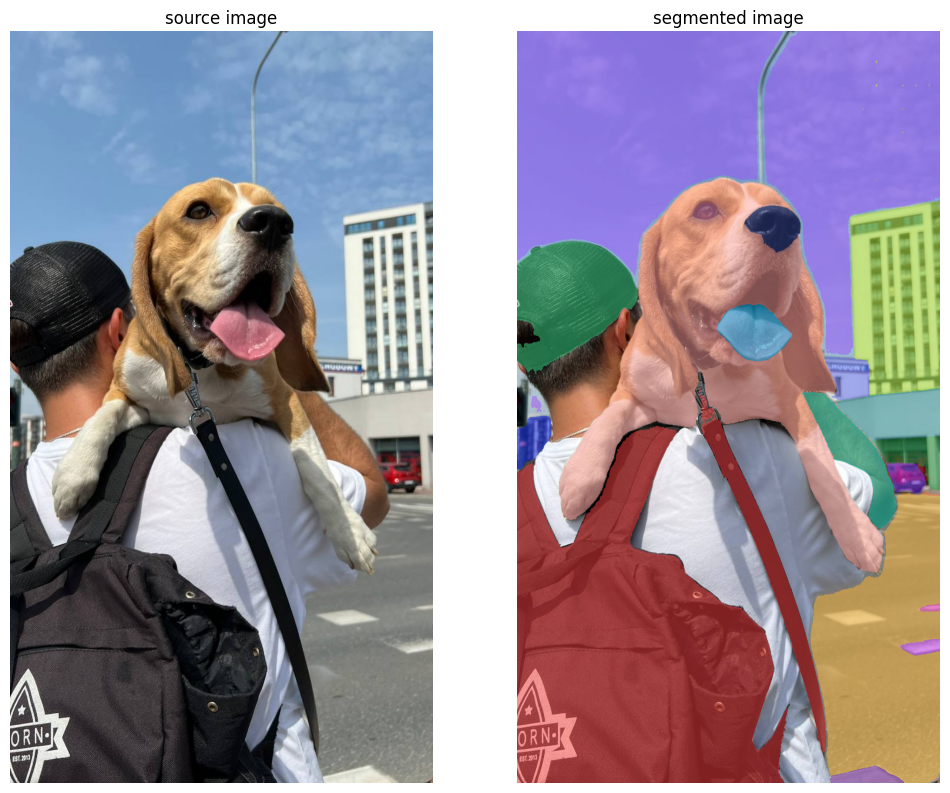

In [19]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=sam2_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [26]:
predictor = SAM2ImagePredictor(sam2_model)
predictor.set_image(rgb)  # Pass RGB image (not BGR)


### `segment_face_hands(image_path, predictor)`
Automatically detects faces and hands using MediaPipe, and uses bounding boxes as prompts for SAM‑2 segmentation.

- Green mask = face  
- Blue mask = hand  
- Input: image path and a SAM predictor  
- Output: visualization with masks overlaid


In [37]:
def segment_face_hands(image_path, predictor, pad=6):
    import cv2
    import mediapipe as mp
    import numpy as np
    import matplotlib.pyplot as plt
#   Initialize media pipe models
    mp_face = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)
    mp_hands = mp.solutions.hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5)

    orig = cv2.imread(image_path)
    h, w = orig.shape[:2]
    rgb = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

    # DETECT face and hand keypoints
    face_results = mp_face.process(rgb)
    hand_results = mp_hands.process(rgb)

    coords = []
    labels = []
#   finding boundary box
    if face_results.detections:
        for det in face_results.detections:
            bb = det.location_data.relative_bounding_box
            x1 = max(int(bb.xmin * w) - pad, 0)
            y1 = max(int(bb.ymin * h) - pad, 0)
            x2 = min(int(bb.xmin * w + bb.width * w) + pad, w)
            y2 = min(int(bb.ymin * h + bb.height * h) + pad, h)
            coords.append((x1, y1, x2, y2))
            labels.append("face")

    if hand_results.multi_hand_landmarks:
        for hand in hand_results.multi_hand_landmarks:
            xs = [lm.x for lm in hand.landmark]
            ys = [lm.y for lm in hand.landmark]
            x1 = max(int(min(xs) * w) - pad, 0)
            y1 = max(int(min(ys) * h) - pad, 0)
            x2 = min(int(max(xs) * w) + pad, w)
            y2 = min(int(max(ys) * h) + pad, h)
            coords.append((x1, y1, x2, y2))
            labels.append("hand")

    #  plot boundary box
    image_with_boxes = orig.copy()
    for (x1, y1, x2, y2) in coords:
        cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), (0, 255, 0), 2)

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Detected Face/Hands")
    plt.show()

    # segmentation using SAM2 , using bounding box as prompt
    predictor.set_image(rgb)
    masks = []
    for box in coords:
        x1, y1, x2, y2 = box
        box_arr = np.array([x1, y1, x2, y2])
        pred = predictor.predict(box=box_arr[None, :])
        masks.append(pred[0][0])

    # visualise the mask
    masked_img = orig.copy()
    for mask, label in zip(masks, labels):
        color_mask = np.zeros_like(masked_img, dtype=np.uint8)
        color = (0, 255, 0) if label == "face" else (255, 0, 0)  # Green face, Blue hand
        color_mask[mask.astype(bool)] = color
        masked_img = cv2.addWeighted(masked_img, 1, color_mask, 0.4, 0)

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Segmented Output")
    plt.show()


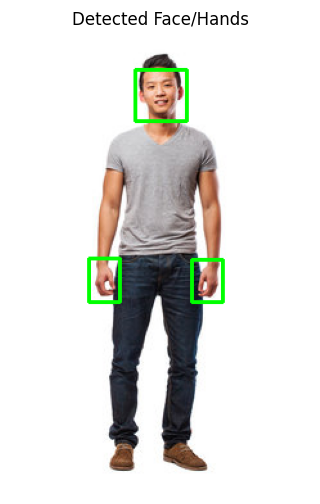

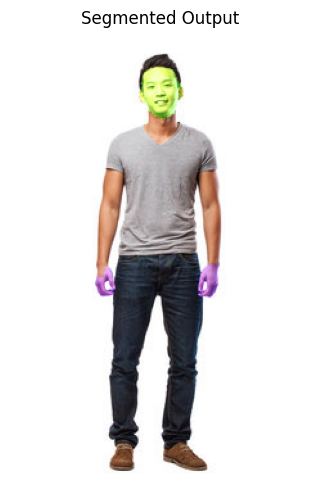

In [38]:
segment_face_hands("/content/man.jpg", predictor)


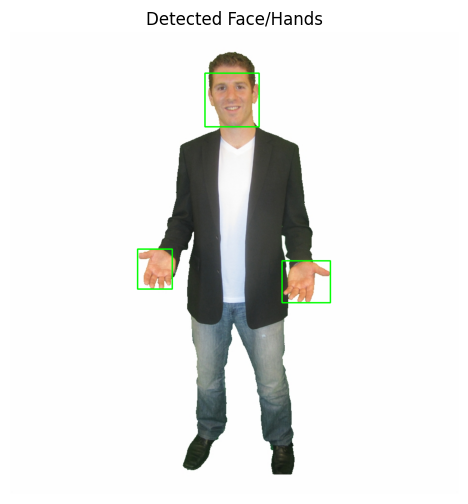

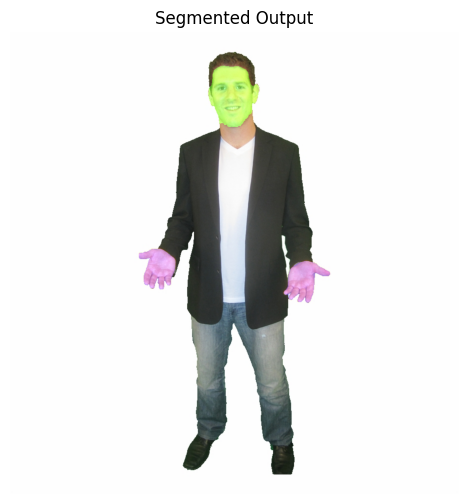

In [40]:
segment_face_hands("/content/man2.png", predictor)


In [43]:

def segment_face_hands_gardio(img_array, predictor, pad=6):

    # Convert RGB to BGR for OpenCV drawing
    orig = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
    h, w = orig.shape[:2]
    rgb = img_array  # keep a copy for MediaPipe + SAM

    # Initialize MediaPipe detectors
    mp_face = mp.solutions.face_detection.FaceDetection(model_selection=1,
                                                        min_detection_confidence=0.5)
    mp_hands = mp.solutions.hands.Hands(static_image_mode=True,
                                        max_num_hands=2,
                                        min_detection_confidence=0.5)

    # Run detections
    face_results = mp_face.process(rgb)
    hand_results = mp_hands.process(rgb)

    coords, labels = [], []

    # Extract face bounding boxes
    if face_results.detections:
        for det in face_results.detections:
            bb = det.location_data.relative_bounding_box
            x1 = max(int(bb.xmin * w) - pad, 0)
            y1 = max(int(bb.ymin * h) - pad, 0)
            x2 = min(int((bb.xmin + bb.width) * w) + pad, w)
            y2 = min(int((bb.ymin + bb.height) * h) + pad, h)
            coords.append((x1, y1, x2, y2))
            labels.append("face")

    # Extract hand bounding boxes
    if hand_results.multi_hand_landmarks:
        for hand in hand_results.multi_hand_landmarks:
            xs = [lm.x for lm in hand.landmark]
            ys = [lm.y for lm in hand.landmark]
            x1 = max(int(min(xs) * w) - pad, 0)
            y1 = max(int(min(ys) * h) - pad, 0)
            x2 = min(int(max(xs) * w) + pad, w)
            y2 = min(int(max(ys) * h) + pad, h)
            coords.append((x1, y1, x2, y2))
            labels.append("hand")

    # Draw bounding boxes
    image_with_boxes = orig.copy()
    for (x1, y1, x2, y2), label in zip(coords, labels):
        color = (0,255,0) if label=="face" else (255,0,0)
        cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), color, 2)

    box_img = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)

    # Run SAM2 segmentation prompts
    predictor.set_image(rgb)
    masks = []
    for (x1, y1, x2, y2) in coords:
        box_arr = np.array([x1, y1, x2, y2])
        pred = predictor.predict(box=box_arr[None, :])
        masks.append(pred[0][0])

    # Overlay masks
    masked_img = orig.copy()
    for mask, label in zip(masks, labels):
        color_mask = np.zeros_like(masked_img, dtype=np.uint8)
        color = (0,255,0) if label=="face" else (255,0,0)
        color_mask[mask.astype(bool)] = color
        masked_img = cv2.addWeighted(masked_img, 1.0, color_mask, 0.4, 0)

    mask_img = cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB)

    return box_img, mask_img

In [47]:
def gradio_segment(img):
    # img is an H×W×3 RGB NumPy array
    box, mask = segment_face_hands_gardio(img, predictor)
    return box, mask



## Face & Hand Segmentation Demo

Run a simple web UI that lets you upload an image and see MediaPipe‑based boxes + SAM2 segmentation masks.

In [49]:
import gradio as gr

gr.Interface(
    fn=gradio_segment,
    inputs=gr.Image(type="numpy", label="Upload or Drag‑Drop"),
    outputs=[gr.Image(type="numpy", label="Boxes"), gr.Image(type="numpy", label="Masks")],
    title="Face & Hand Segmentation"
).launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://08b27966dc5e3e9104.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
